In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import mplhep as hep
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'
!pip install uproot
import uproot as ur


plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [3]:
cmap = mpl.cm.get_cmap('viridis')

#norm = mpl.colors.LogNorm(vmin=0.1, vmax=100.0)
MIP=0.000472


In [4]:
def position(row,col, sl, offsetX,offsetY):
    x=col*1.5*sl+offsetX+sl/2
    y=row*np.sqrt(3)/2*sl+ offsetY+sl*np.sqrt(3)/2
    return x,y

In [16]:
Rm=3.1
def draw_Rm(ax,z, pxpz, pypz, **arg):
    ph=np.linspace(-np.pi, np.pi, 101)
    ax.plot(np.repeat(z, len(ph)), pxpz*z+Rm*np.cos(ph), pypz*z+Rm*np.sin(ph), **arg)

In [36]:
def mx(a,b):
    return a*(a>b)+b*(b>=a)

def calc_zorder(z):
    return 35000/10+1620/10-z


import matplotlib.ticker as ticker

def show_shower(input_file, event, layer, x_offset=0, z_range=None, y_range=None, x_range=None, prefix='ZDCHcal',
               w0_nrw=4.0, w0_rw=5.0):
    MIP=0.000472
    cmap = mpl.cm.get_cmap('viridis')
    
    fig=plt.figure(figsize=(16, 16))
    ax0 = fig.add_subplot(311, projection='3d',azim=-104, elev=20,computed_zorder=False)
    ax1 = fig.add_subplot(312, projection='3d',azim=-104, elev=20,computed_zorder=False)
    ax2 = fig.add_subplot(313, projection='3d',azim=-104, elev=20,computed_zorder=False)
    plt.sca(ax1)
    events = ur.open(f'{input_file}:events')
    arrays_sim = events.arrays()
    #print(arrays_sim.fields)

    E=arrays_sim[f'{prefix}HitsReco.energy'][event,:]
    x=arrays_sim[f'{prefix}HitsReco.position.x'][event,:]/10-x_offset
    y=arrays_sim[f'{prefix}HitsReco.position.y'][event,:]/10
    z=arrays_sim[f'{prefix}HitsReco.position.z'][event,:]/10
    sl=arrays_sim[f'{prefix}HitsReco.dimension.x'][event,0]/2/10
    
    px,py,pz=[arrays_sim[f'MCParticles.momentum.{a}'][event,2] for a in 'xyz']
    xtruth=35000/10*(px/pz-x_offset/(35000/10))
    ytruth=35000/10*py/pz
    window=4*sl
    
    
    phi=np.linspace(-np.pi, np.pi, 7)
    dx=sl*np.cos(phi)
    dy=sl*np.sin(phi)
    dz=0*phi
    MIP=0.000472
    
    
    layers_z=sorted(list(set(z)))
    
    norm = mpl.colors.LogNorm(vmin=.1, vmax=max(E)/MIP)

    w0=w0_nrw
    Etot=sum(E)
    w=w0+np.log((E+.0000001)/Etot)
    w=w*(w>0)
    alpha=w/max(w)
    
    if x_range is None:
        x_range=xtruth-window/2,xtruth+window/2
    if y_range is None:
        y_range=ytruth-window/2,ytruth+window/2
    
    in_window=(x >x_range[0]) & (x <x_range[1]) & (y <y_range[1]) & \
                            (y>y_range[0])
    
    for i in range(len(E)):
        
        if not in_window[i]:
            continue
        
        vx = x[i]+dx
        vy = y[i]+dy
        vz = z[i]+dz
        verts = [list(zip(vz,vx,vy))]
        #if alpha[i]>0:
        ax1.add_collection3d(Poly3DCollection(verts, alpha=1, color=cmap(alpha[i]),
                            zorder=calc_zorder(z[i])))
        ax0.add_collection3d(Poly3DCollection(verts, color=cmap(norm(E[i]/MIP)),
                            zorder=calc_zorder(z[i])))
        #print(x[i], y[i], z[i])
        
    
    print([sorted(list(set(np.round(a[in_window], 2)))) for a in (x,y,z)])
    #run HEXSPLIT
    plt.sca(ax2)
    
    xnew=[]
    ynew=[]
    znew=[]
    Enew=[]
    orient=[]
    phi=np.linspace(0, np.pi*5/3, 6)
    cph=np.cos(phi)
    sph=np.sin(phi)
    
    thresh=Etot*np.exp(-w0_rw)
    b=0.01
    
    dz_layers=layers_z[1]-layers_z[0]
    
    for i in range(len(x)):
        if not in_window[i]:
            continue
        Eneighbors=[0,0,0,0,0,0]
        for j in range(len(x)):
            if not in_window[j]:
                continue
            if abs(z[i]-z[j])>dz_layers*1.1 or  E[j]<thresh or  j == i :
                continue
            dx=(x[j]-x[i])/sl
            dy=(y[j]-y[i])/sl
            if abs(dx)>1.1 or abs(dy)>1.1:
                continue
            tol=0.01
            for k in range(6):
                if abs(dx-cph[k])<tol and abs(dy-sph[k])<tol:
                    #print("found neighbor")
                    Eneighbors[k]=E[j]
                    #print(Eneighbors, E[j])
                    break
        a=MIP
        Eneighbors=np.array(Eneighbors)
        #print(Eneighbors)
        reweight_energy=mx(np.roll(Eneighbors,0),a)*mx(np.roll(Eneighbors,-1),a)
        reweight_energy/=sum(reweight_energy)
        #print(reweight_energy)
        for k in range(6):
            
            
            xnew.append(x[i]+sl*np.array([0,cph[k],cph[k-5]]))
            ynew.append(y[i]+sl*np.array([0,sph[k],sph[k-5]]))
            znew.append(z[i]+np.array([0,0,0]))
            Enew.append(E[i]*reweight_energy[k])
            #orient.append(k%2)
            
    w0=w0_rw
    Enew=np.array(Enew)
    Etot=sum(Enew)
    wnew=w0+np.log((Enew+.0000001)/Etot)
    wnew=wnew*(wnew>0)
    alpha=wnew/max(wnew)
    #alpha=1*(alpha>0)
    
    dx=sl*np.cos(phi)
    dy=sl*np.sin(phi)
    dz=0*phi
    
    for i in range(len(xnew)):
        #w0=4
        #if not alpha[i]>0:
        #    continue
        vx = xnew[i]
        vy = ynew[i]
        vz = znew[i]
        verts = [list(zip(vz,vx,vy))]
        #print(verts[0])
        
        ax2.add_collection3d(Poly3DCollection(verts, 
                                              alpha=1, color=cmap(alpha[i]),
                            zorder=calc_zorder(znew[i][0])))
    
    
    
    
    phi=np.linspace(-np.pi, np.pi, 7)
    cph=np.cos(phi)
    sph=np.sin(phi)
    
    for ax in ax1, ax2, ax0:
        #ax.axis('off')
        if z_range is None:
            ax.set_xlim(min(z[w>0]), max(z[w>0]-2*dz_layers))
        else :
            ax.set_xlim(z_range)
        ax.set_ylim(xtruth-window/2, xtruth+window/2)
        ax.set_zlim(ytruth-window/2, ytruth+window/2)
        ax.set_box_aspect((4,1,1))
        for i in range(len(layers_z)-1):
            zz=np.array(layers_z[i:i+2])
            #print(zz)
            zorder=calc_zorder((layers_z[i]+layers_z[i+1])/2)
            ax.plot(zz, zz*(px/pz-x_offset/35000*10), zz*py/pz,  color='r', ls='-',
                   zorder=zorder)
            
            
            #draw_Rm(ax, zz[0], px/pz-x_offset/35000*10, py/pz, color='#ff00ff', 
            #        ls='--',zorder=calc_zorder(zz[0]),lw=0.75)
            for row in range(-5, 5):
                for col in range(-5,5):
                    if (row+col)%2: 
                        continue
                    xi,yi=position(row,col, sl, 0, 0)
                    xi+=(-2+i%3)*sl
                    if xi >x_range[0] and xi <x_range[1] and yi <y_range[1] and \
                            yi >y_range[0]:
                        ax.plot([zz[0]]*7, xi+cph*sl, yi+sl*sph, color='0.5', linewidth=1,
                               zorder=calc_zorder(zz[0]))
            ax.set_xlabel("\n\nz [cm]")
            ax.set_ylabel("\nx [cm]")
            ax.set_zlabel("\ny [cm]")
            
            ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
            ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
            
            ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
            ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
            
            ax.zaxis.set_major_locator(ticker.MultipleLocator(5))
            ax.zaxis.set_minor_locator(ticker.MultipleLocator(1))
            
            #@ticker.FuncFormatter
            def major_formatter(x, pos):
                return f'{int(x-3500)}'

            #setup(axs1[2], title='FuncFormatter("[{:.2f}]".format)')
            ax.xaxis.set_major_formatter(major_formatter)
    
    left=0; bottom=0.74; width=1; height=0.5
    ax0.set_position([left, bottom, width, height])
    
    left=0; bottom=0.37; width=1; height=0.5
    ax1.set_position([left, bottom, width, height])
    
    left=0; bottom=0; width=1; height=0.5
    ax2.set_position([left, bottom, width, height])
    print(pz)
    
    for y,label,norm in [(0.09, "sub-cell weight (arbitrary units)", mpl.colors.Normalize(vmin=0, vmax=max(wnew))),
                    (0.46, "hit weight (arbitrary units)", mpl.colors.Normalize(vmin=0, vmax=max(w))),
                    (0.83, "hit energy [MIP]", mpl.colors.LogNorm(vmin=0.1, vmax=max(E)/MIP))]:
        cm = mpl.cm
        cax=fig.add_subplot()
        cax.set_position([0.25, y, .5, 0.025])
        cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal',
                         aspect=20)
        cb.set_label(label)
        cb.solids.set_edgecolor("face")
    #ax1.set_title("Before subcell-splitting")
    #ax2.set_title("After subcell-splitting")
    #fig.tight_layout()
    
    
    for ax, label in zip((ax0, ax1, ax2), ("Shower at hit level", "baseline reconstruction", "HEXPLIT")):
        ax.text2D(0.05, 0.7, label, transform=ax.transAxes)
    
    return ax0, ax1,ax2

[[-6.26, -4.69, -3.13, -1.57, 0.0, 1.57, 3.13, 4.69, 6.26], [2.71, 5.42, 8.13, 10.84, 13.55], [3504.72, 3509.69, 3512.18, 3514.68, 3519.66, 3522.14, 3524.64, 3529.61, 3532.1, 3534.6, 3537.09, 3539.58, 3542.06, 3544.56, 3547.04, 3549.54, 3552.02, 3554.52, 3557.0, 3559.5, 3561.98, 3564.48, 3566.96, 3569.46, 3571.94, 3574.44, 3576.92, 3579.41, 3581.9, 3584.4, 3586.89, 3589.38, 3591.86, 3594.36, 3596.84, 3599.34, 3601.82, 3604.32, 3606.81, 3609.3, 3611.78, 3614.28, 3616.76, 3619.26, 3621.74, 3624.24, 3626.72, 3629.22, 3631.7, 3634.19, 3636.68, 3639.18, 3641.66, 3644.16, 3646.64, 3649.14, 3651.62, 3654.11, 3656.6, 3659.1, 3661.59, 3664.08, 3666.56]]
224.93002


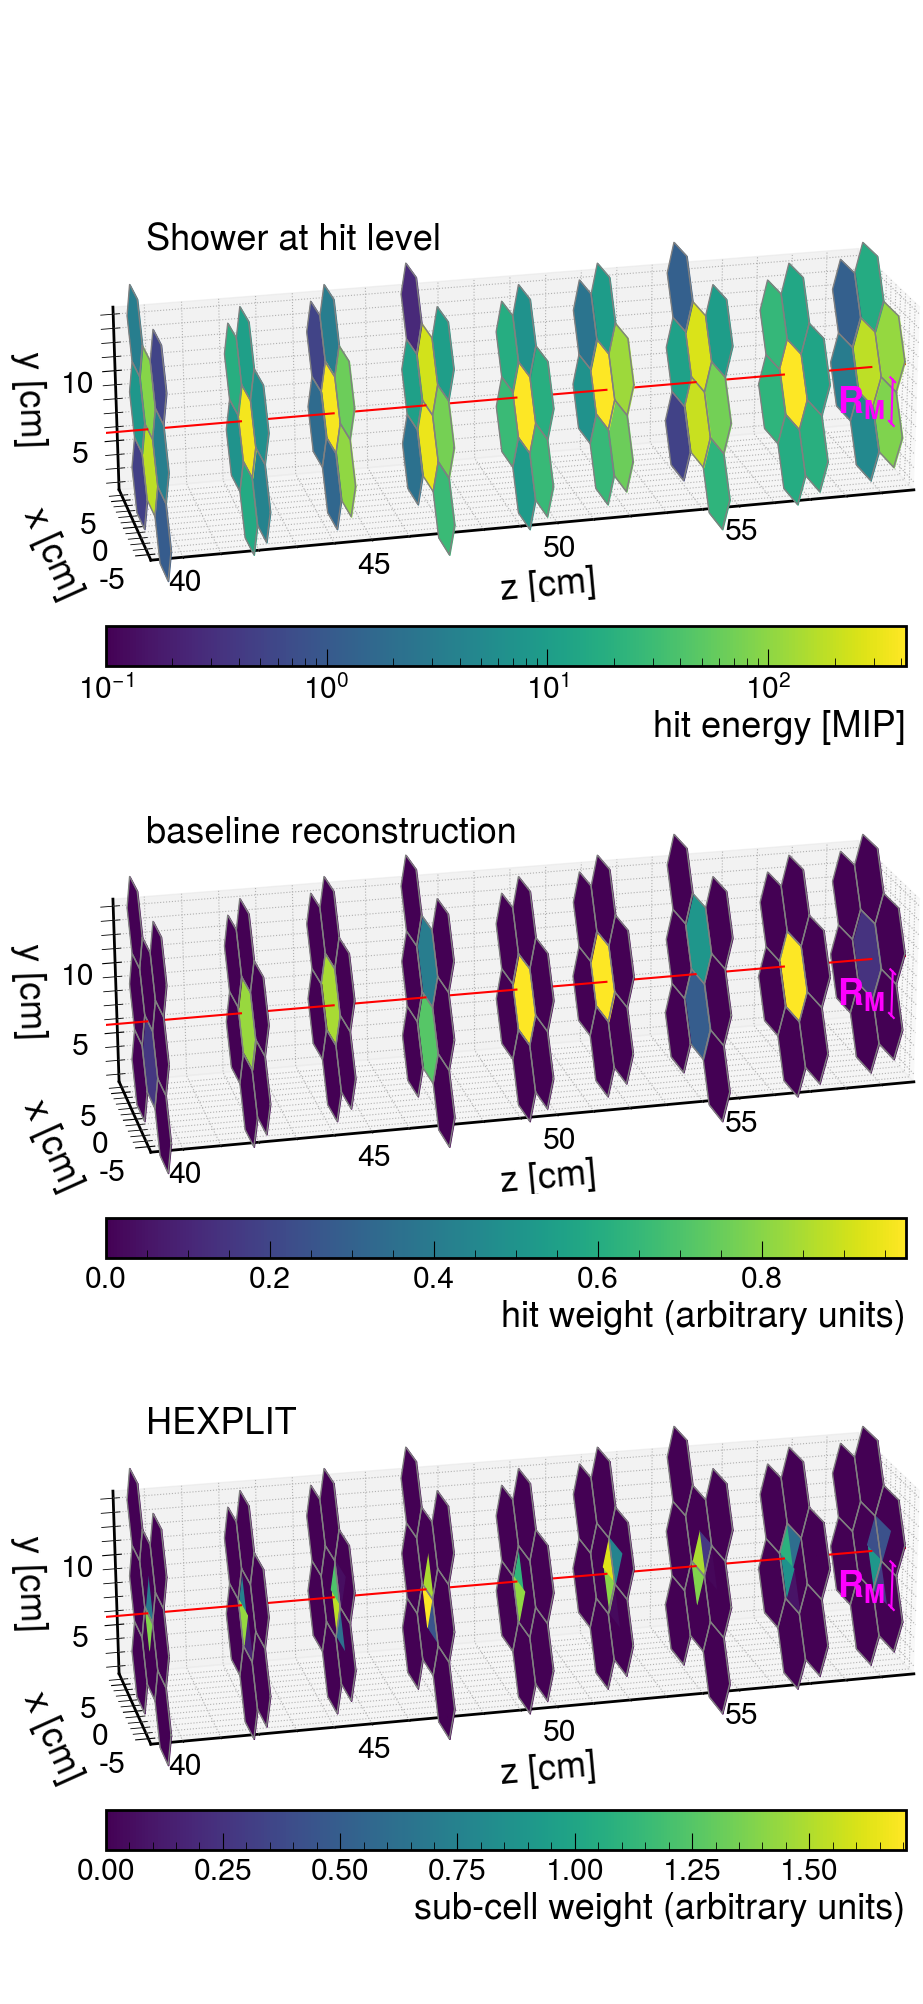

In [28]:
    
    
axs=show_shower("/Users/spaul/Downloads/zdc_reco_neutron_discrete_1GeV-300GeV_theta_0deg-0.5deg_633303_125.edm4hep.root", 
            2, 0, x_offset=-35000*.025/10, 
            x_range=[-70/10, 70/10], y_range=[26/10, 136/10])

#show the RM
# x=-9.5
# y=5
# z=3546.6
x=-10.5
y=6
z=3556.5
x=-7.5
y=7
z=3559
for ax in axs:
    RM=3.1
    a=.5
    ax.plot([z,z],[x,x], [y,y+RM], color='#ff00ff',zorder=calc_zorder(z))
    ax.plot([z,z],[x-a,x+a], [y,y], color='#ff00ff',zorder=calc_zorder(z))
    ax.plot([z,z],[x-a,x+a], [y+RM,y+RM], color='#ff00ff', 
             zorder=1000)
    ax.text(z-0.2,x,y+RM/2, "$R_M$", color='#ff00ff', zorder=calc_zorder(z), weight='bold',
            va='center', ha='right')
    #ax.text(z-0.2,x+1,y+RM/2, "$R_M$", color='#ff00ff', zorder=calc_zorder(z), weight='bold',
    #        va='center', ha='left')

plt.savefig("algorithm_illustration.pdf")


plt.show()

[[-9.39, -7.82, -6.26, -4.7, -3.13, -1.56, -0.0, 1.56], [0.0, 2.71, 5.42, 8.13], [3504.72, 3507.2, 3509.69, 3512.18, 3514.68, 3517.16, 3519.66, 3522.14, 3524.64, 3527.12, 3529.61, 3532.1, 3534.6, 3537.09, 3539.58, 3542.06, 3544.56, 3547.04, 3549.54, 3552.02, 3554.52, 3557.0, 3559.5, 3561.98, 3564.48, 3574.44]]
199.99982


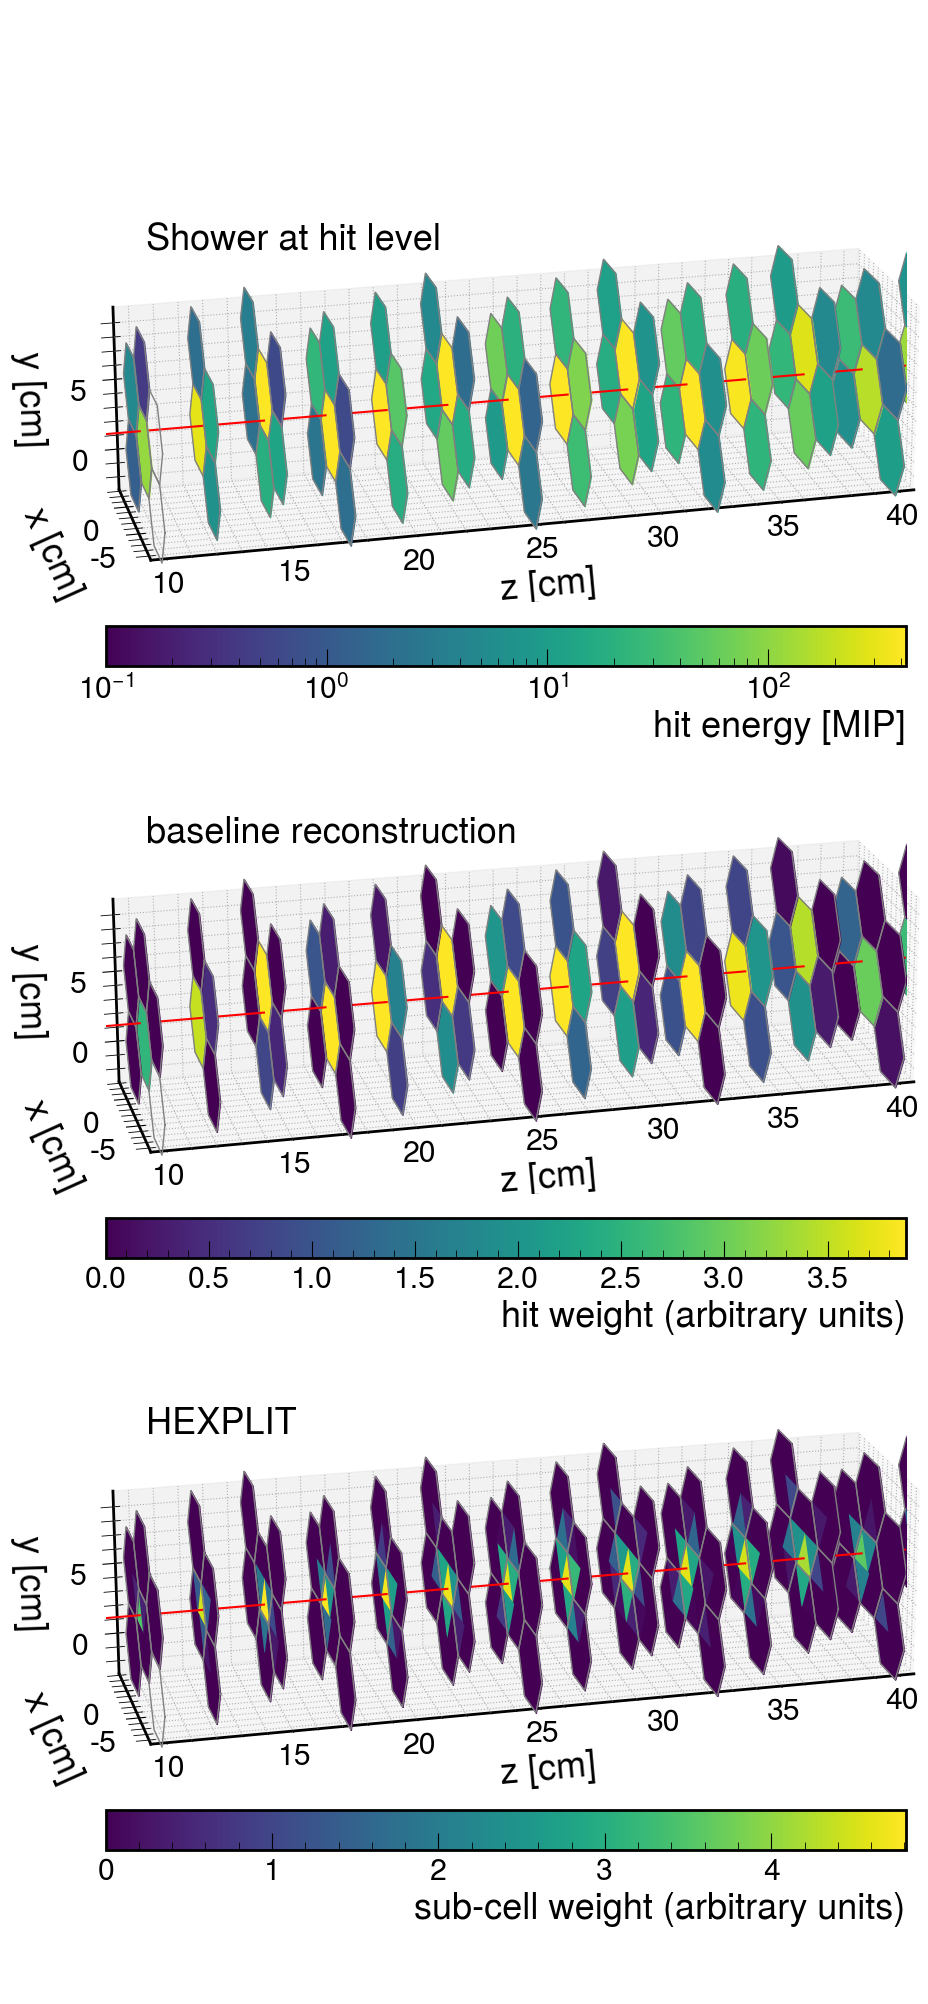

In [38]:
axs=show_shower("dd4hep/zdc_staggered_h3_inf_reco_gamma_200GeV_theta_deg.edm4hep.root", 
            2, 0, x_offset=0, prefix="ZDC", w0_nrw=6.2+np.log(200/50)*.3, 
                w0_rw=6.9+np.log(200/50)*.5, z_range=[35000/10+10, 35000/10+40])#, z_range=[35000/10, ], 
            #x_range=[-70/10, 70/10], y_range=[26/10, 136/10])

#show the RM
# x=-9.5
# y=5
# z=3546.6
x=-10.5
y=6
z=3556.5
x=-7.5
y=7
z=3559
for ax in axs:
    RM=3.1
    a=.5
    ax.plot([z,z],[x,x], [y,y+RM], color='#ff00ff',zorder=calc_zorder(z))
    ax.plot([z,z],[x-a,x+a], [y,y], color='#ff00ff',zorder=calc_zorder(z))
    ax.plot([z,z],[x-a,x+a], [y+RM,y+RM], color='#ff00ff', 
             zorder=1000)
    ax.text(z-0.2,x,y+RM/2, "$R_M$", color='#ff00ff', zorder=calc_zorder(z), weight='bold',
            va='center', ha='right')
    #ax.text(z-0.2,x+1,y+RM/2, "$R_M$", color='#ff00ff', zorder=calc_zorder(z), weight='bold',
    #        va='center', ha='left')

plt.savefig("algorithm_illustration_photon.pdf")


plt.show()

In [200]:
np.roll([1,2,3], 1)

array([3, 1, 2])

In [319]:
help(plt.colorbar)

Help on function colorbar in module matplotlib.pyplot:

colorbar(mappable=None, cax=None, ax=None, **kw)
    Add a colorbar to a plot.
    
    Parameters
    ----------
    mappable
        The `matplotlib.cm.ScalarMappable` (i.e., `~matplotlib.image.AxesImage`,
        `~matplotlib.contour.ContourSet`, etc.) described by this colorbar.
        This argument is mandatory for the `.Figure.colorbar` method but optional
        for the `.pyplot.colorbar` function, which sets the default to the current
        image.
    
        Note that one can create a `.ScalarMappable` "on-the-fly" to generate
        colorbars not attached to a previously drawn artist, e.g. ::
    
            fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    
    cax : `~matplotlib.axes.Axes`, optional
        Axes into which the colorbar will be drawn.
    
    ax : `~matplotlib.axes.Axes`, list of Axes, optional
        One or more parent axes from which space for a new colorbar axes will be
      

AttributeError: 'Colorbar' object has no attribute 'get_axes'

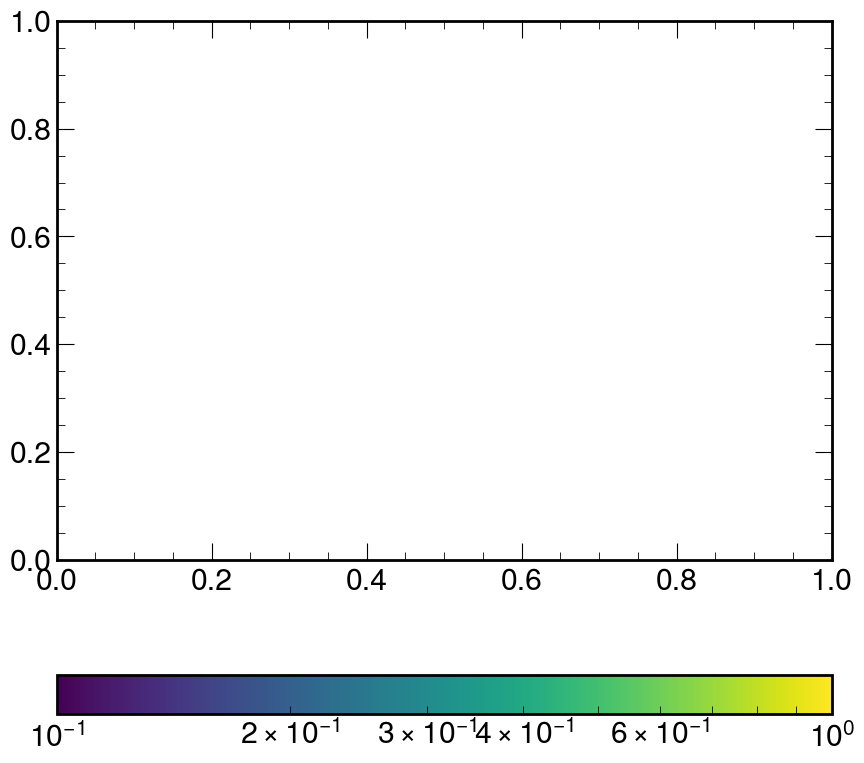

In [338]:
fig,axs = plt.subplots(1,1,figsize=(10,10))
cm = mpl.cm
norm= mpl.colors.LogNorm(vmin=0.1, vmax=1)
cmap = mpl.cm.get_cmap('viridis')
cax=fig.add_subplot()
cax.set_position([0, 0, 1, 0.1])
cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), orientation='horizontal')
cb.solids.set_edgecolor("face")

plt.show()

In [353]:
help(mpl.colors.Normalize)

Help on class Normalize in module matplotlib.colors:

class Normalize(builtins.object)
 |  Normalize(vmin=None, vmax=None, clip=False)
 |  
 |  A class which, when called, linearly normalizes data into the
 |  ``[0.0, 1.0]`` interval.
 |  
 |  Methods defined here:
 |  
 |  __call__(self, value, clip=None)
 |      Normalize *value* data in the ``[vmin, vmax]`` interval into the
 |      ``[0.0, 1.0]`` interval and return it.
 |      
 |      Parameters
 |      ----------
 |      value
 |          Data to normalize.
 |      clip : bool
 |          If ``None``, defaults to ``self.clip`` (which defaults to
 |          ``False``).
 |      
 |      Notes
 |      -----
 |      If not already initialized, ``self.vmin`` and ``self.vmax`` are
 |      initialized using ``self.autoscale_None(value)``.
 |  
 |  __init__(self, vmin=None, vmax=None, clip=False)
 |      Parameters
 |      ----------
 |      vmin, vmax : float or None
 |          If *vmin* and/or *vmax* is not given, they are initializ